In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, Complementarity

# Computing State-space Model from transfer function

$$ y(s) = \dfrac{1}{125s^3 + 75s^2 + 15s + 1} \ u(s) $$

State-space representation from the transfer function above (from matlab):

In [2]:
A = [2.45619225923395 -2.01096013810692 0.548811636094027; 
    1 0 0;
    0 1 0]
B = [0.0625; 0; 0]
C = [0.0183756999177941, 0.0633113580621751, 0.0136128264831647];

System configuration

In [3]:
# Sampling time
T = 1
# Simulation time in sampling periods
nsim = 75
# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1
# Number of states
nx = 3;

Controller configuration

In [4]:
# Output prediction horizon
p = 30
# Input control horizon 
m = 3
# Output weights
q = 1
# Input weights aggressive = 1 | detuned = 20
r = 1;

DRTO configuration

In [5]:
# Prediction horizon
pD = 50
# Input control horizon 
mD = 20;

Setting parameters for matrices for DRTO

In [6]:
# Initial condition
x0 = [0.0 0.0668429 8.88317 0.0 0.0668429 8.88317;
 0.0 0.015 8.71151 0.0 0.015 8.71151;
 0.0 0.0 8.51842 0.0 0.0 8.51842];

u0 = [0 0.3 0.5 0.8 1.0 1.1];

# setting bounds 
ΔUMax = 0.3
uMax = 1.2 # 1.2
uMin = 0.0
yMax = 1.5
yMin = 0.0
yspMax = 1.5
yspMin = 0.0;

# Solving CL-DRTO Problem

## Building matrices for MPC


Given the following discrete state-space model:

$ x(k+1) = A \ x(k) + b \ u(k) $ <br>
$ y(k) = C \ x(k)$ <br>

Using the supperposition property of linear systems, we obtain the model outputs from instants $k+1$ to $k+j$ as:
$ y(k + 1|k) = C \ x(k + 1|k) = CA \ x(k) + CB \ u(k|k)$ <br>
$ y(k + 2|k) = CA^2 \ x(k) + CAB \ u(k|k) + CB \ u(k+1|k)$ <br>
$ y(k + 3|k) = CA^3 \ x(k) + CA^2B \ u(k|k) + CAB \ u(k+1|k) + CB \ u(k+2|k)$ <br>
$ ... $ <br>
$ y(k + j|k) = CA^j \ x(k) + CA^{j-1}B \ u(k|k) + CA^{j-2}B \ u(k+1|k) + \cdots + CB \ u(k + j -1|k)$ 

Suppose now that:<br>
$ u(k + m|k) = u(k + m + 1|k) = \cdots = u(k + p - 1|k)$

The equations above (when $j > m$) can then be re-written as:
$ y(k + m + 1|k) = CA^{m+1} \ x(k) + CA^{m}B \ u(k|k) + CA^{m-1}B \ u(k+1|k) + \cdots + [CAB + CB] \ u(k + m -1|k)$ <br>
$ y(k + m + 2|k) = CA^{m+2} \ x(k) + CA^{m+1}B \ u(k|k) + CA^{m}B \ u(k+1|k) + \cdots + [CA^2B + CAB + CB] \ u(k + m -1|k)$ <br>
$ ... $ <br>
$ y(k + pk) = CA^{p} \ x(k) + CA^{p-1}B \ u(k|k) + CA^{p-2}B \ u(k+1|k) + \cdots + [CA^{p-m}B + CA^{p-m-1}B + \cdots + CB] \ u(k + m -1|k)$

Thus, the vector of output predictions can be written as follows:

$
\begin{vmatrix}
y(k + 1|k)\\
y(k + 2|k)\\
\vdots \\
y(k + m|k) \\
y(k + m + 1|k)\\ 
\vdots \\
y(k + p|k)
\end{vmatrix}
= 
\begin{vmatrix}
CA\\
CA^{2}\\
\vdots \\
CA^{m} \\
CA^{m+1}\\ 
\vdots \\
CA^{p}
\end{vmatrix} \ x(k)
+
\begin{vmatrix}
CB        & 0         & \cdots & 0\\
CAB       & CB        & \cdots & 0\\
\vdots    & \vdots    & \cdots & \vdots\\
CA^{m-1}B & CA^{m-2}B & \cdots & CB\\
CA^{m}B   & CA^{m-1}B & \cdots & C\tilde{A}_1B\\ 
\vdots    & \vdots    & \cdots & \vdots\\
CA^{p-1}B & CA^{p-2}B & \cdots & C\tilde{A}_{p-m}B
\end{vmatrix} 
\begin{vmatrix}
u(k|k)\\
u(k + 2|k)\\
\vdots \\
u(k + m - 1|k) 
\end{vmatrix}
$

where: <br>
$\tilde{A}_1 = A + I, \quad \tilde{A}_2 = A^2 + A + I, \quad \tilde{A}_{p-m} = A^{p-m} + A^{p-m-1} + \cdots + I$

Simpifying, we have: <br>
$ \bar{y}(k) = \Psi \ x(k) + \Theta \ u(k) $ 

In [7]:
Psi = C'*A
for ii in 2:p
    Psi = [Psi;  C'*A^ii]
end

# Computing Dynamic Matirx
a = [C'*A^(ii - 1)*B for ii in 1:p];
DynM = a

for ii in 1:(m - 2)
    a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
    DynM = [DynM  a]
end

# adjusting dynamic matrix for since p > m (last column)
b = C'*B

Ai = I(nx)
for ii = 1:(p - m)
    Ai = Ai + A^ii
    b = [b;C'*Ai*B]
end

Theta=[DynM [zeros(ny*(m-1),nu);b]];

The first term (output tracking) of the MPC objective function is: 

$ \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) $

which can be written as:

$ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) $

where: 
$ \bar{Q} = diag\bigg( Q, \cdots, Q\bigg)$ - $p$ repetitions of $Q$

The second term (inputs movement penalization) of the MPC objective function is: 

$ \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $

We observe that:
$
\begin{vmatrix}
\Delta u(k|k)\\
\Delta u(k + 1|k)\\
\vdots \\
\Delta u(k + m - 1|k) 
\end{vmatrix}
= 
\begin{vmatrix}
u(k|k) - u(k - 1)\\
u(k + 1|k) - u(k|k)\\
\vdots \\
u(k + m - 1|k) - u(k + m - 2|k)
\end{vmatrix}
=
u_k - Mu_k - \bar{I} u(k - 1)
= (I_{nu,m} - M)u_k - \bar{I} u(k - 1)
= I_M u_k - \bar{I} u(k - 1)
$

in which:
$
M = 
\begin{vmatrix}
0_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
I_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
0_{nu} & I_{nu} & \cdots & 0_{nu} & 0_{nu}\\
\vdots & \vdots & \cdots & \vdots & \vdots\\
0_{nu} & 0_{nu} & \cdots & I_{nu} & 0_{nu}
\end{vmatrix}, \quad
\bar{I} = 
\begin{vmatrix}
I_{nu}\\
0_{nu}\\
0_{nu}\\
\vdots\\
0_{nu}
\end{vmatrix}
$

the second term can be written as:

$ (I_M u_k - \bar{I} u(k - 1))^T \ \bar{R} \ (I_M u_k - \bar{I} u(k - 1)) $

where: 
$ \bar{R} = diag\bigg( R, \cdots, R\bigg)$ - $m$ repetitions of $R$

In [8]:
# Creating Qbar and Rbar matrices
Qbar = Diagonal([q for ii in 1:p])
Rbar = Diagonal([r for ii in 1:m])

# Creating input movement OF penalty matrix 
M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
Ibar=[I(nu); zeros(nu*(m-1),nu)]
IM = I(nu*m) - M';

The objective function then can be reduced to a quadratic function of the form:
$$ J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

where:

$H = \Theta^T \ \bar{Q} \ \Theta + I_M^T \ \bar{R} \ I_M$ <br>
$c_f^T = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ \Theta + u(k-1)^T\bar{I}^T \ \bar{R} \ I_M$ <br>
$c = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) + u(k-1)^T\bar{I}^T \ \bar{R} \ \bar{I} \ u(k-1)$

In [9]:
# Matrix H
H = Theta'*Qbar*Theta+IM'*Rbar*IM;

## Constrained MPC optimization problem

Since we are considering constraints, the optimization problem reads as:

$$ min_{u_k} J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

$$ s.t.: u_{min} \leq u_k \leq u_{max}  \quad k = 1,\ldots,m $$ 
 
considering m = 3, we can rewrite the constraints as:

$ u_k - u_{max} \leq 0 \quad k = 1,2,3  $ <br>
$ u_{min} - u_k \leq 0 \quad k = 1,2,3  $ <br>

## Solving problem via KKT

The Lagrangian of the problem above is: 
$$ L = u_k^T \ H \ u_k + 2c_f^T \ u_k + c + 
\begin{vmatrix}
\mu_{UB,1} \ \mu_{UB,2} \ \mu_{UB,3} \ \mu_{LB,1} \ \mu_{LB,2} \ \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
$$

The KKT conditions can be written as

- Stationarity of the Lagrangian <br>
$ \nabla_u L = 
\begin{vmatrix}
u_{1} & u_{2} & u_{3}
\end{vmatrix} 
\ H + c_f^T +  
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix} 
\begin{vmatrix}
1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ -1 & 0 & 0 \\ 0 & -1 & 0 \\ 0 & 0 & -1
\end{vmatrix}
$ <br>

- Primal Feasibility <br>
$
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
\leq 0
$ <br>

- Dual Feasibility <br>
$
\begin{vmatrix}
\mu_{UB,1} \\ \mu_{UB,2} \\ \mu_{UB,3} \\ \mu_{LB,1} \\ \mu_{LB,2} \\ \mu_{LB,3}
\end{vmatrix}
\geq 0
$ <br>

- Complementarity Slackness <br>
$
\begin{vmatrix}
\mu_{UB,1} & \mu_{UB,2} & \mu_{UB,3} & \mu_{LB,1} & \mu_{LB,2} & \mu_{LB,3}
\end{vmatrix}
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
= 0
$

# Solving complementarity slackness using binaries

Defining: <br>
$
\boldsymbol{g} := 
\begin{vmatrix}
u_1 - u_{max} \\ u_2 - u_{max} \\ u_3 - u_{max} \\ u_{min} - u_1 \\ u_{min} - u_2 \\ u_{min} - u_3
\end{vmatrix}
$ <br>

The complementarity slackness becomes: <br>
$ \boldsymbol{\mu}^\top \ \boldsymbol{g} = 0 $

which can be rearranged into linear constraints using the big-M strategy:<br>
for $j = 1,\ldots,n_g$ <br>
$ \boldsymbol{\mu}_j \geq 0 $ <br>
$ \boldsymbol{\mu}_j \leq MY_j $ <br>
$ \boldsymbol{g}_j \leq 0 $ <br>
$ \boldsymbol{g}_j \geq M(1 - Y_j) $ <br>

where: <br>
$M$ is a large constant <br>
and $Y = \{0,1\}$ is a binary variable

## Function: solving CL-DRTO + constrained MPC (binaries - big-M)
- Given initial state and previous plant input

In [10]:
# Parameters
# matrix to compute the gradients of the input bound constraints
conMatrix = [1 0 0;
             0 1 0;
             0 0 1;
            -1 0 0;
             0 -1 0;
             0 0 -1]; 

# big-M implementation
bigM = 6000;

In [11]:
function CLDRTO_con_bin(xInit,uInit)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant

    # Define subproblem model
    m_con_bin = Model(CPLEX.Optimizer)
    # set_silent(m_con_bin) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_con_bin, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_con_bin, yMin <= y[1:pD] <= yMax)

    # SP model outputs
    @variable(m_con_bin, yspMin <= ysp[1:pD] <= yspMax)
    
    # inputs computed by MPCs
    @variable(m_con_bin, u[1:pD,1:m])
    @variable(m_con_bin, mu_g[1:pD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    @variable(m_con_bin, Y_ub[1:pD,1:m], Bin)
    @variable(m_con_bin, Y_lb[1:pD,1:m], Bin)
    
    # slacks for controlling setpoint into a zone
    @variable(m_con_bin, delta_y_p[1:pD] >= 0)
    @variable(m_con_bin, delta_y_m[1:pD] >= 0)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(m_con_bin, Min, sum(u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

    #####################
    # Set up DRTO model #
    #####################
    # Dynamic RTO model (linear)
    @constraint(m_con_bin, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_con_bin, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_con_bin, CLDRTO_model_out[kk=1:pD], y[kk] == C'*x[kk,:])

    ##########################################
    # Set up MPC constraints and expressions #
    ##########################################    
    @expression(m_con_bin, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_con_bin, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)
    
    # stationarity
    @constraint(m_con_bin, MPC_sol_1, u[1,:]'*H + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
    @constraint(m_con_bin, MPC_sol[kk=2:mD], u[kk,:]'*H + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

    # primal feasibility
    @constraint(m_con_bin, MPC_u_upper[kk = 1:mD,uu = 1:m], u[kk,uu] - uMax <= 0)
    @constraint(m_con_bin, MPC_u_lower[kk = 1:mD,uu = 1:m], uMin - u[kk,uu] <= 0)
    
    # big-M implementation
    @constraint(m_con_bin, bigM_1[kk = 1:mD,uu = 1:m], mu_g[kk,uu] <= bigM*Y_ub[kk,uu])
    @constraint(m_con_bin, bigM_2[kk = 1:mD,uu = 1:m], mu_g[kk,uu + m] <= bigM*Y_lb[kk,uu])
    @constraint(m_con_bin, bigM_3[kk = 1:mD,uu = 1:m], u[kk,uu] - uMax >= -bigM*(1 - Y_ub[kk,uu]))
    @constraint(m_con_bin, bigM_4[kk = 1:mD,uu = 1:m], uMin - u[kk,uu] >= -bigM*(1 - Y_lb[kk,uu]))

    @constraint(m_con_bin, compSlack[kk = 1:mD,uu = 1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)

    # fixing input after mD
    @constraint(m_con_bin, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # Δu constraints
    #@constraint(m_con_bin, ΔU_max_0, -ΔUMax <= u[1] - uInit <= ΔUMax)
    #@constraint(m_con_bin, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

    # y (DRTO) inside target quality band
    @constraint(m_con_bin, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
    @constraint(m_con_bin, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05)

    # @show model_ms
    
    optimize!(m_con_bin)
    flag = termination_status(m_con_bin)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_con_bin)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    
    # lagrange multipliers associated with the nonantecipativity constraints
    #λ = dual.(control_horizon)
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray)
end;

## Function: solving CL-DRTO + constrained MPC (binaries - indicator)
- Using indicator constraints in-built in JuMP

Indicator constraints consist of a binary variable and a linear constraint. The constraint holds when the binary variable takes the value 1. The constraint may or may not hold when the binary variable takes the value 0.

In [12]:
function CLDRTO_con_ind(xInit,uInit)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant

    # Define subproblem model
    m_con_ind = Model(CPLEX.Optimizer)
    #set_silent(m_con_ind) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_con_ind, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_con_ind, yMin <= y[1:pD] <= yMax)

    # SP model outputs
    @variable(m_con_ind, yspMin <= ysp[1:pD] <= yspMax)
    
    # inputs computed by MPCs
    @variable(m_con_ind, u[1:pD,1:m])
    @variable(m_con_ind, mu_g[1:mD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    @variable(m_con_ind, Y_ub[1:mD,1:m], Bin)
    @variable(m_con_ind, Y_lb[1:mD,1:m], Bin)
    
    # slacks for controlling setpoint into a zone
    @variable(m_con_ind, delta_y_p[1:pD] >= 0)
    @variable(m_con_ind, delta_y_m[1:pD] >= 0)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(m_con_ind, Min, sum(u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

    #####################
    # Set up DRTO model #
    #####################
    # Dynamic RTO model (linear)
    @constraint(m_con_ind, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_con_ind, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_con_ind, CLDRTO_model_out[kk=1:pD], y[kk] == C'*x[kk,:])

    ##########################################
    # Set up MPC constraints and expressions #
    ##########################################    
    @expression(m_con_ind, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_con_ind, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)
    
    # stationarity
    @constraint(m_con_ind, MPC_sol_1, u[1,:]'*H + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
    @constraint(m_con_ind, MPC_sol[kk=2:mD], u[kk,:]'*H + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

    # primal feasibility
    @constraint(m_con_ind, g_u_u[kk = 1:mD,uu = 1:m], uMax - u[kk,uu] ≥ 0)
    @constraint(m_con_ind, g_u_l[kk = 1:mD,uu = 1:m], u[kk,uu] - uMin ≥ 0)

    # complementarity slackness
    @constraint(m_con_ind, MPC_c_upper[kk = 1:mD,uu = 1:m], Y_ub[kk,uu] => {uMax - u[kk,uu] == 0})
    @constraint(m_con_ind, MPC_c_lower[kk = 1:mD,uu = 1:m], Y_lb[kk,uu] => {u[kk,uu] - uMin == 0})

    @constraint(m_con_ind, MPC_c_upper_dual[kk = 1:mD,uu = 1:m], !Y_ub[kk,uu] => {mu_g[kk,uu] == 0})
    @constraint(m_con_ind, MPC_c_lower_dual[kk = 1:mD,uu = 1:m], !Y_lb[kk,uu] => {mu_g[kk,uu + m] == 0})
    
    @constraint(m_con_ind, compSlack[kk = 1:mD,uu = 1:m], Y_ub[kk,uu] + Y_lb[kk,uu] ≤ 1)
    
    # fixing input after mD
    @constraint(m_con_ind, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # Δu constraints
    #@constraint(m_con_bin, ΔU_max_0, -ΔUMax <= u[1] - uInit <= ΔUMax)
    #@constraint(m_con_bin, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

    # y (DRTO) inside target quality band
    @constraint(m_con_ind, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
    @constraint(m_con_ind, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05)

    # @show model_ms
    
    optimize!(m_con_ind)
    flag = termination_status(m_con_ind)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_con_ind)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    
    # lagrange multipliers associated with the nonantecipativity constraints
    #λ = dual.(control_horizon)
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray)
end;

# Solving Complementary using MPCC

The complementarity slackness is now moved to the objective function: <br>

$ max_{u_k} \ \boldsymbol{\mu}^\top \ \boldsymbol{g} $ <br>
s.t.: <br>
$ \nabla L = 0 $ <br>
$ u - u_{max} \leq 0 \quad j = 1,\ldots,n_g $ <br>
$ u_{min} - u \leq 0 \quad j = 1,\ldots,n_g $ <br>
$ \boldsymbol{\mu}_j \geq 0 \quad j = 1,\ldots,n_g $ <br>

## Function: solving CL-DRTO + constrained MPC (MPCC)
- Given initial state and previous plant input

In [13]:
function CLDRTO_con_mpec(xInit,uInit,pi_bar)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # pi_bar - weight for the complementarity relaxation term in OF

    # Define subproblem model
    m_con_mpec = Model(Ipopt.Optimizer)
    set_silent(m_con_mpec) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_con_mpec, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_con_mpec, yMin <= y[1:pD] <= yMax)

    # SP model outputs
    @variable(m_con_mpec, yspMin <= ysp[1:pD] <= yspMax)
    
    # inputs computed by MPCs
    @variable(m_con_mpec, u[1:pD,1:m])
    @variable(m_con_mpec, mu_g[1:pD,1:(2*m)] ≥ 0) # upper and lower bounds for each input
    
    # slacks for controlling setpoint into a zone
    @variable(m_con_mpec, delta_y_p[1:pD] >= 0)
    @variable(m_con_mpec, delta_y_m[1:pD] >= 0)

    #####################
    # Set up DRTO model #
    #####################
    # Dynamic RTO model (linear)
    @constraint(m_con_mpec, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_con_mpec, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_con_mpec, CLDRTO_model_out[kk=1:pD], y[kk] == C'*x[kk,:])

    ##########################################
    # Set up MPC constraints and expressions #
    ##########################################    
    @expression(m_con_mpec, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_con_mpec, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)
    
    # stationarity
    @constraint(m_con_mpec, MPC_sol_1, u[1,:]'*H + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
    @constraint(m_con_mpec, MPC_sol[kk=2:mD], u[kk,:]'*H + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

    # primal feasibility
    @expression(m_con_mpec, g_u_u[kk = 1:mD,uu = 1:m], u[kk,uu] - uMax)
    @expression(m_con_mpec, g_u_l[kk = 1:mD,uu = 1:m], uMin - u[kk,uu])

    @constraint(m_con_mpec, MPC_c_upper[kk = 1:mD,uu = 1:m], g_u_u[kk,uu] <= 0)
    @constraint(m_con_mpec, MPC_c_lower[kk = 1:mD,uu = 1:m], g_u_l[kk,uu] <= 0)
    
    # fixing input after mD
    @constraint(m_con_mpec, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # Δu constraints
    #@constraint(m_con_bin, ΔU_max_0, -ΔUMax <= u[1] - uInit <= ΔUMax)
    #@constraint(m_con_bin, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

    # y (DRTO) inside target quality band
    @constraint(m_con_mpec, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
    @constraint(m_con_mpec, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(m_con_mpec, Min, 
            sum(
                u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) 
                for kk in 1:pD)
            - pi_bar*sum(
                  sum(mu_g[kk,jj]*g_u_u[kk,jj] for jj = 1:m) +
                  sum(mu_g[kk,jj + m]*g_u_l[kk,jj] for jj = 1:m)
                  for kk = 1:mD)
            )
    # @show model_ms
    
    optimize!(m_con_mpec)
    flag = termination_status(m_con_mpec)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_con_mpec)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    muArray = value.(mu_g)
    g_u_Array = uArray - uMax*ones(pD,m)
    g_l_Array = uMin*ones(pD,m) - uArray
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray, 'm' => muArray, 'g' => [g_u_Array g_l_Array])
end;

# Finding the weights for the interior penalty method for MPCC solution


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



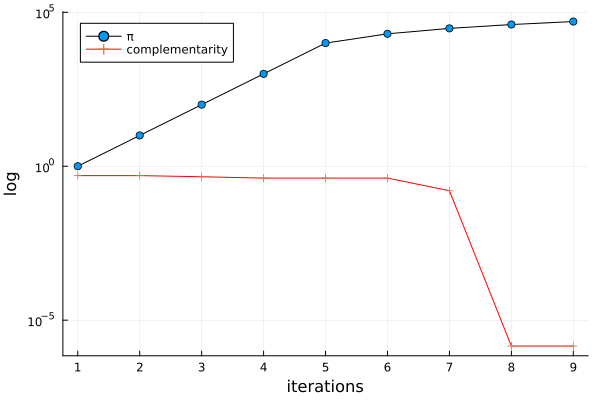

In [14]:
# trial weights for complementarity relaxation OF term
pi_w_Array = [1 10 10^2 10^3 10^4 2*10^4 3*10^4 4*10^4 5*10^4] 

nTest = length(pi_w_Array)

comp_gap = Vector{Float64}(undef,nTest) 

for ii = 1:nTest
    # solving problem with relaxed complementarity slackness
    sol_temp = CLDRTO_con_mpec(x0[:,1],u0[1],pi_w_Array[ii])

    # checking the complementarity gap for all MPC's
    com_gap_temp = 0
    for kk = 1:mD
        temp = abs(sum(sol_temp['m'][kk,jj]*sol_temp['g'][kk,jj] for jj = 1:(2*m)))
        com_gap_temp = com_gap_temp + temp
    end
    
    # saving information
    comp_gap[ii] = com_gap_temp
end

gr()

p1 = plot(1:nTest,pi_w_Array', yaxis="log",xaxis="iterations",linecolor = :black,marker= :circle,
            xticks = 1:nTest,legend=:topleft,yscale=:log10)
p1 = plot!(1:nTest,comp_gap, linecolor = :red,marker= :cross,xticks = 1:nTest,yscale=:log10,legend=:topleft)
p1.series_list[1][:label] = "π"
p1.series_list[2][:label] = "complementarity"

display(p1)

## Function: solving CL-DRTO + constrained MPC (complementarity package)
- Given initial state and previous plant input

For solving mathematical programs with equilibrium constraints (MPEC), this package provides an extension to JuMP.jl by providing a macro that accepts complementarity conditions as constraints. Then it reformulates the complementarity conditions as a set of equality and inequality constraints so that a nonlinear optimization solver such as Ipopt.jl can solve the problem. See the documentation. <br>

$ min  f(x) $ <br>
$ \quad s.t. \ g(x) \leq 0 $ <br>
$ \quad\quad \ F(x) \perp lb \leq x \leq ub $

In [15]:
function CLDRTO_con_cc(xInit,uInit)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant

    # Define subproblem model
    m_con_cc = Model(Ipopt.Optimizer)
    #set_silent(m_con_cc) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_con_cc, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_con_cc, yMin <= y[1:pD] <= yMax)

    # SP model outputs
    @variable(m_con_cc, yspMin <= ysp[1:pD] <= yspMax)
    
    # inputs computed by MPCs
    @variable(m_con_cc, u[1:pD,1:m])
    @variable(m_con_cc, mu_g[1:pD,1:(2*m)]) # upper and lower bounds for each input
    
    # slacks for controlling setpoint into a zone
    @variable(m_con_cc, delta_y_p[1:pD] >= 0)
    @variable(m_con_cc, delta_y_m[1:pD] >= 0)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(m_con_cc, Min, sum(u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

    #####################
    # Set up DRTO model #
    #####################
    # Dynamic RTO model (linear)
    @constraint(m_con_cc, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_con_cc, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_con_cc, CLDRTO_model_out[kk=1:pD], y[kk] == C'*x[kk,:])

    ##########################################
    # Set up MPC constraints and expressions #
    ##########################################    
    @expression(m_con_cc, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_con_cc, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)
    
    # stationarity
    @constraint(m_con_cc, MPC_sol_1, u[1,:]'*H + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
    @constraint(m_con_cc, MPC_sol[kk=2:mD], u[kk,:]'*H + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

    # primal/dual feasibility + complementarity slackness
    for kk in 1:mD
        for uu in 1:m
            @complements(m_con_cc, 0 ≤ uMax - u[kk,uu], mu_g[kk,uu] ≥ 0)
            @complements(m_con_cc, 0 ≤ u[kk,uu] - uMin, mu_g[kk,uu + m] ≥ 0)
        end
    end
    
    # fixing input after mD
    @constraint(m_con_cc, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # Δu constraints
    #@constraint(m_con_bin, ΔU_max_0, -ΔUMax <= u[1] - uInit <= ΔUMax)
    #@constraint(m_con_bin, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

    # y (DRTO) inside target quality band
    @constraint(m_con_cc, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
    @constraint(m_con_cc, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05)

    # @show model_ms
    
    optimize!(m_con_cc)
    flag = termination_status(m_con_cc)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_con_cc)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    
    # lagrange multipliers associated with the nonantecipativity constraints
    #λ = dual.(control_horizon)
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray)
end;

## Function: solving CL-DRTO + unconstrained MPC (for comparison)
- Given initial state and previous plant input

In [16]:
function CLDRTO_unc(xInit,uInit)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant

    # Define subproblem model
    m_unc = Model(CPLEX.Optimizer)
    set_silent(m_unc) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO states
    @variable(m_unc, x[1:pD, 1:nx])
    # DRTO model outputs
    @variable(m_unc, yMin <= y[1:pD] <= yMax)

    # SP model outputs
    @variable(m_unc, yspMin <= ysp[1:pD] <= yspMax)
    
    # inputs computed by MPCs
    @variable(m_unc, uMin <= u[1:pD,1:m] <= uMax)
    
    # slacks for controlling setpoint into a zone
    @variable(m_unc, delta_y_p[1:pD] >= 0)
    @variable(m_unc, delta_y_m[1:pD] >= 0)

    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(m_unc, Min, sum(u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(m_unc, CLDRTO_dyn_model_1, x[1,:] .== A*xInit + B*uInit)
    @constraint(m_unc, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1])
    @constraint(m_unc, CLDRTO_model_out[kk=1:pD], y[kk] == C'*x[kk,:])

    # Unconstrained MPC solution
    @expression(m_unc, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(m_unc, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)

    @constraint(m_unc, MPC_sol_1, H*u[1,:] + cfT_1' .== 0)
    @constraint(m_unc, MPC_sol[kk=2:mD], H*u[kk,:] + cfT[kk]' .== 0)
    
    # fixing input after mD
    @constraint(m_unc, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);
    
    # Δu constraints
    #@constraint(m_unc, ΔU_max_0, -ΔUMax <= u[1] - uInit <= ΔUMax)
    #@constraint(m_unc, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

    # y (DRTO) inside target quality band
    @constraint(m_unc, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
    @constraint(m_unc, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05)

    # @show model_ms
    
    optimize!(m_unc)
    flag = termination_status(m_unc)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(m_unc)
    uArray = value.(u)
    yspArray = value.(ysp)
    yArray = value.(y)
    
    return Dict('o' => o, 'f' => flag, 'u' => uArray, 'y' => yArray, 's' => yspArray)
end;

# Plotting results for comparison

In [17]:
sol_con_bin = CLDRTO_con_bin(x0[:,1],u0[1])

# Get values for plotting
uTraj_bin = Vector{Float64}(undef,pD) 
yspTraj_bin = Vector{Float64}(undef,pD)
yTraj_bin = Vector{Float64}(undef,pD)

for kk in 1:pD
    yTraj_bin[kk] = sol_con_bin['y'][kk]
    yspTraj_bin[kk] = sol_con_bin['s'][kk]
    uTraj_bin[kk] = sol_con_bin['u'][kk]
end;

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Found incumbent of value 4512500.000000 after 0.00 sec. (0.07 ticks)
Tried aggregator 3 times.
MIQP Presolve eliminated 196 rows and 437 columns.
MIQP Presolve added 120 rows and 0 columns.
MIQP Presolve modified 262 coefficients.
Aggregator did 136 substitutions.
Reduced MIQP has 598 rows, 527 columns, and 3520 nonzeros.
Reduced MIQP has 120 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 92 nonzeros.
Presolve time = 0.01 sec. (10.09 ticks)
Probing fixed 0 vars, tightened 189 bounds.
Probing time = 0.00 sec. (2.34 ticks)
Tried aggregator 1 time.
MIQP Presolve eliminated 4 rows and 2 columns.
MIQP Presolve modified 236 coefficients.
Reduced MIQP has 594 rows, 525 columns, and 3511 nonzeros.
Reduced MIQP has 119 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 92 nonzeros.
Presolve time = 0.00 sec. (0.99 ticks)
Classifier predicts products in MIQP should be linear

In [18]:
sol_con_ind = CLDRTO_con_ind(x0[:,1],u0[1])

display(sol_con_ind['f'])

# Get values for plotting
uTraj_ind = Vector{Float64}(undef,pD) 
yspTraj_ind = Vector{Float64}(undef,pD)
yTraj_ind = Vector{Float64}(undef,pD)

for kk in 1:pD
    yTraj_ind[kk] = sol_con_ind['y'][kk]
    yspTraj_ind[kk] = sol_con_ind['s'][kk]
    uTraj_ind[kk] = sol_con_ind['u'][kk]
end;

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Found incumbent of value 4512500.000000 after 0.00 sec. (0.06 ticks)
Tried aggregator 3 times.
MIQP Presolve eliminated 136 rows and 77 columns.
MIQP Presolve modified 22 coefficients.
Aggregator did 137 substitutions.
Reduced MIQP has 417 rows, 526 columns, and 3158 nonzeros.
Reduced MIQP has 120 binaries, 0 generals, 0 SOSs, and 120 indicators.
Reduced MIQP objective Q matrix has 92 nonzeros.
Presolve time = 0.00 sec. (9.67 ticks)
Probing fixed 0 vars, tightened 192 bounds.
Probing time = 0.00 sec. (2.03 ticks)
Tried aggregator 1 time.
MIQP Presolve eliminated 2 rows and 1 columns.
Reduced MIQP has 445 rows, 525 columns, and 3214 nonzeros.
Reduced MIQP has 119 binaries, 0 generals, 0 SOSs, and 88 indicators.
Reduced MIQP objective Q matrix has 92 nonzeros.
Presolve time = 0.00 sec. (3.43 ticks)
Classifier predicts products in MIQP should be linearized.
Probing fixed 0 vars, tightened 93 bounds.
Probing time = 0.00 sec. (0.85 ticks

OPTIMAL::TerminationStatusCode = 1

In [19]:
sol_con_mpcc = CLDRTO_con_mpec(x0[:,1],u0[1],5*10^4)

#test = maximum(sol_con_mpcc['m'])
#display(test)

# Get values for plotting
uTraj_mpcc = Vector{Float64}(undef,pD) 
yspTraj_mpcc = Vector{Float64}(undef,pD)
yTraj_mpcc = Vector{Float64}(undef,pD)

for kk in 1:pD
    yTraj_mpcc[kk] = sol_con_mpcc['y'][kk]
    yspTraj_mpcc[kk] = sol_con_mpcc['s'][kk]
    uTraj_mpcc[kk] = sol_con_mpcc['u'][kk]
end;

In [20]:
#sol_con_cc = CLDRTO_con_cc(x0[:,1],u0[1])

# Get values for plotting
#uTraj_cc = Vector{Float64}(undef,pD) 
#yspTraj_cc = Vector{Float64}(undef,pD)
#yTraj_cc = Vector{Float64}(undef,pD)

#for kk in 1:pD
#    yTraj_cc[kk] = sol_con_cc['y'][kk]
#    yspTraj_cc[kk] = sol_con_cc['s'][kk]
#    uTraj_cc[kk] = sol_con_cc['u'][kk]
#end;

In [21]:
sol_unc = CLDRTO_unc(x0[:,1],u0[1])

# Get values for plotting
uTraj_unc = Vector{Float64}(undef,pD) 
yspTraj_unc = Vector{Float64}(undef,pD)
yTraj_unc = Vector{Float64}(undef,pD)

for kk in 1:pD
    yTraj_unc[kk] = sol_unc['y'][kk]
    yspTraj_unc[kk] = sol_unc['s'][kk]
    uTraj_unc[kk] = sol_unc['u'][kk]
end;

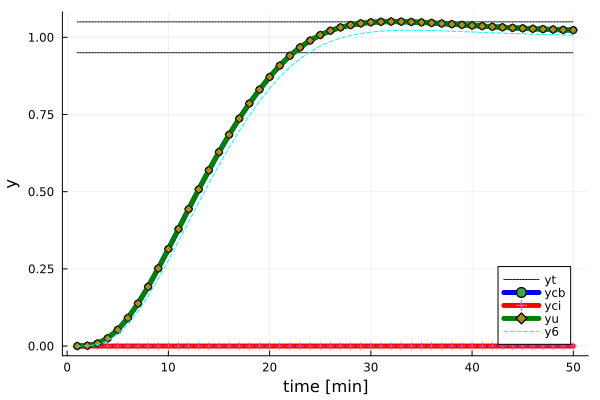

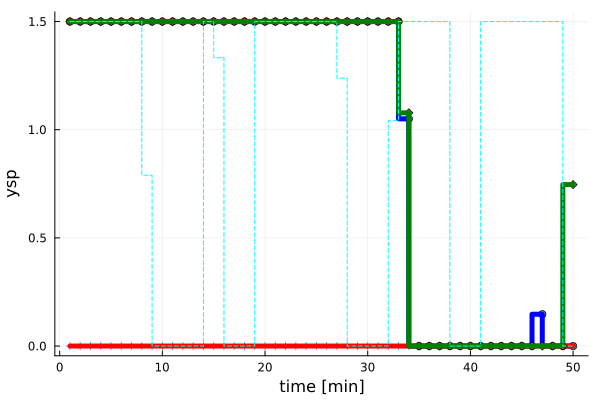

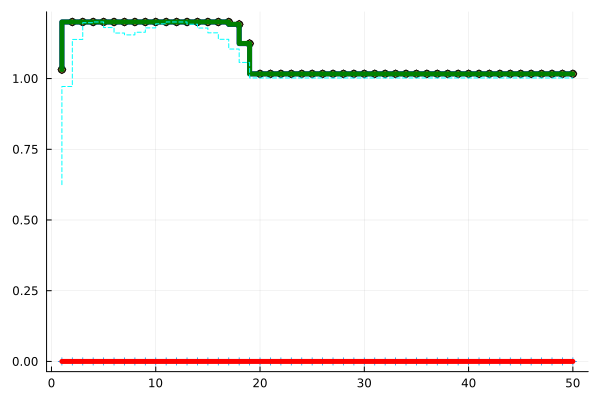

In [22]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

gr()

p1 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,yTraj_bin,linewidth=5,marker= :circle,xaxis="time [min]",yaxis="y",linecolor = :blue)
p1 = plot!(ts,yTraj_ind,linewidth=5,marker= :cross,linecolor = :red)
p1 = plot!(ts,yTraj_mpcc,linewidth=5,marker= :diamond,linecolor = :green)
p1 = plot!(ts,yTraj_unc,linestyle=:dash,linecolor = :cyan)
p1.series_list[1][:label] = "yt"
p1.series_list[2][:label] = ""
p1.series_list[3][:label] = "ycb"
p1.series_list[4][:label] = "yci"
p1.series_list[5][:label] = "ympcc"
p1.series_list[5][:label] = "yu"
display(p1)

p2 = plot(ts,yspTraj_bin,linewidth=5,marker= :circle,xaxis="time [min]",yaxis="ysp",linecolor = :blue,linetype=:steppre,legend=false)
p2 = plot!(ts,yspTraj_ind,linewidth=5,marker= :cross,linecolor = :red,linetype=:steppre,legend=false)
p2 = plot!(ts,yspTraj_mpcc,linewidth=5,marker= :diamond,linecolor = :green,linetype=:steppre,legend=false)
p2 = plot!(ts,yspTraj_unc,linestyle=:dash,linecolor = :cyan,linetype=:steppre,legend=false)
display(p2)

p3 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time [min]", yaxis="u",legend=false)
p3 = plot(ts,uTraj_bin,linewidth=5,marker= :circle,linecolor = :blue, linetype=:steppre,legend=false)
p3 = plot!(ts,uTraj_ind,linewidth=5,marker= :cross,linecolor = :red, linetype=:steppre,legend=false)
p3 = plot!(ts,uTraj_mpcc,linewidth=5,marker= :diamond,linecolor = :green, linetype=:steppre,legend=false)
p3 = plot!(ts,uTraj_unc,linestyle=:dash,linecolor = :cyan, linetype=:steppre,legend=false)
display(p3)